# Explorative Data Analysis - Seattle Public Life
Data credited to Seattle Open Data Portal [source](https://data.seattle.gov/browse/select_dataset?tags=sidewalks

| Year | Moving Observations | Staying Observations |
|------|--------------------|---------------------|
| 2018 |        1728        |        6537         |
| 2019 |        495         |        4179         |
| 2020 |         56         |         486         |
| 2022 |         99         |        1248         |

Seattle downtown is bounded within 
`x_min, x_max = -122.363604, -122.310561
y_min, y_max = 47.595458, 47.618721`;

Ballard is bounded within
`x_min, x_max = -122.413015, -122.356281
y_min, y_max = 47.655481, 47.698940`.



In [324]:
import pandas as pd 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# from shapely.geometry import Point, Polygon
import seaborn as sns
from matplotlib.patches import Rectangle
import itertools
from matplotlib.animation import FuncAnimation
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [313]:
input_path = '/Users/gracejia/Documents/A-UW/dissertation/street_furniture/github/street_furniture/'
output_path = '/Users/gracejia/Documents/A-UW/dissertation/street_furniture/github/street_furniture/'
# Read the shapefile
geography = gpd.read_file(input_path + 'public_data/Public_Life_Data_Geography_20240122/geo_export_97ecd427-7823-4893-8c48-ef1c0afc6361.shp')
tracts_2010 = gpd.read_file(input_path + "public_data/Census_Tracts_2010.shp")
tracts_2010 = tracts_2010.to_crs(geography.crs)
sidewalks = gpd.read_file(input_path + "public_data/Sidewalks/Sidewalks.shp")
sidewalks = sidewalks.to_crs(geography.crs)
loc = pd.read_csv(input_path + "public_data/Public_Life_Data_-_Locations_20240122.csv")
moving = pd.read_csv(input_path + "public_data/Public_Life_Data_-_People_Moving_20240122.csv")
staying = pd.read_csv(input_path + "public_data/Public_Life_Data_-_People_Staying_20240122.csv")
# geography = geography.to_crs(epsg=4326)

helper functions

In [114]:
# helper functions
def create_moving_column(year):
    if year == 2018:
        return '2018-2019'
    elif year == 2019:
        return '2018-2019'
    elif year == 2020:
        return '2020'
    elif year == 2022:
        return '2022'

Area overview

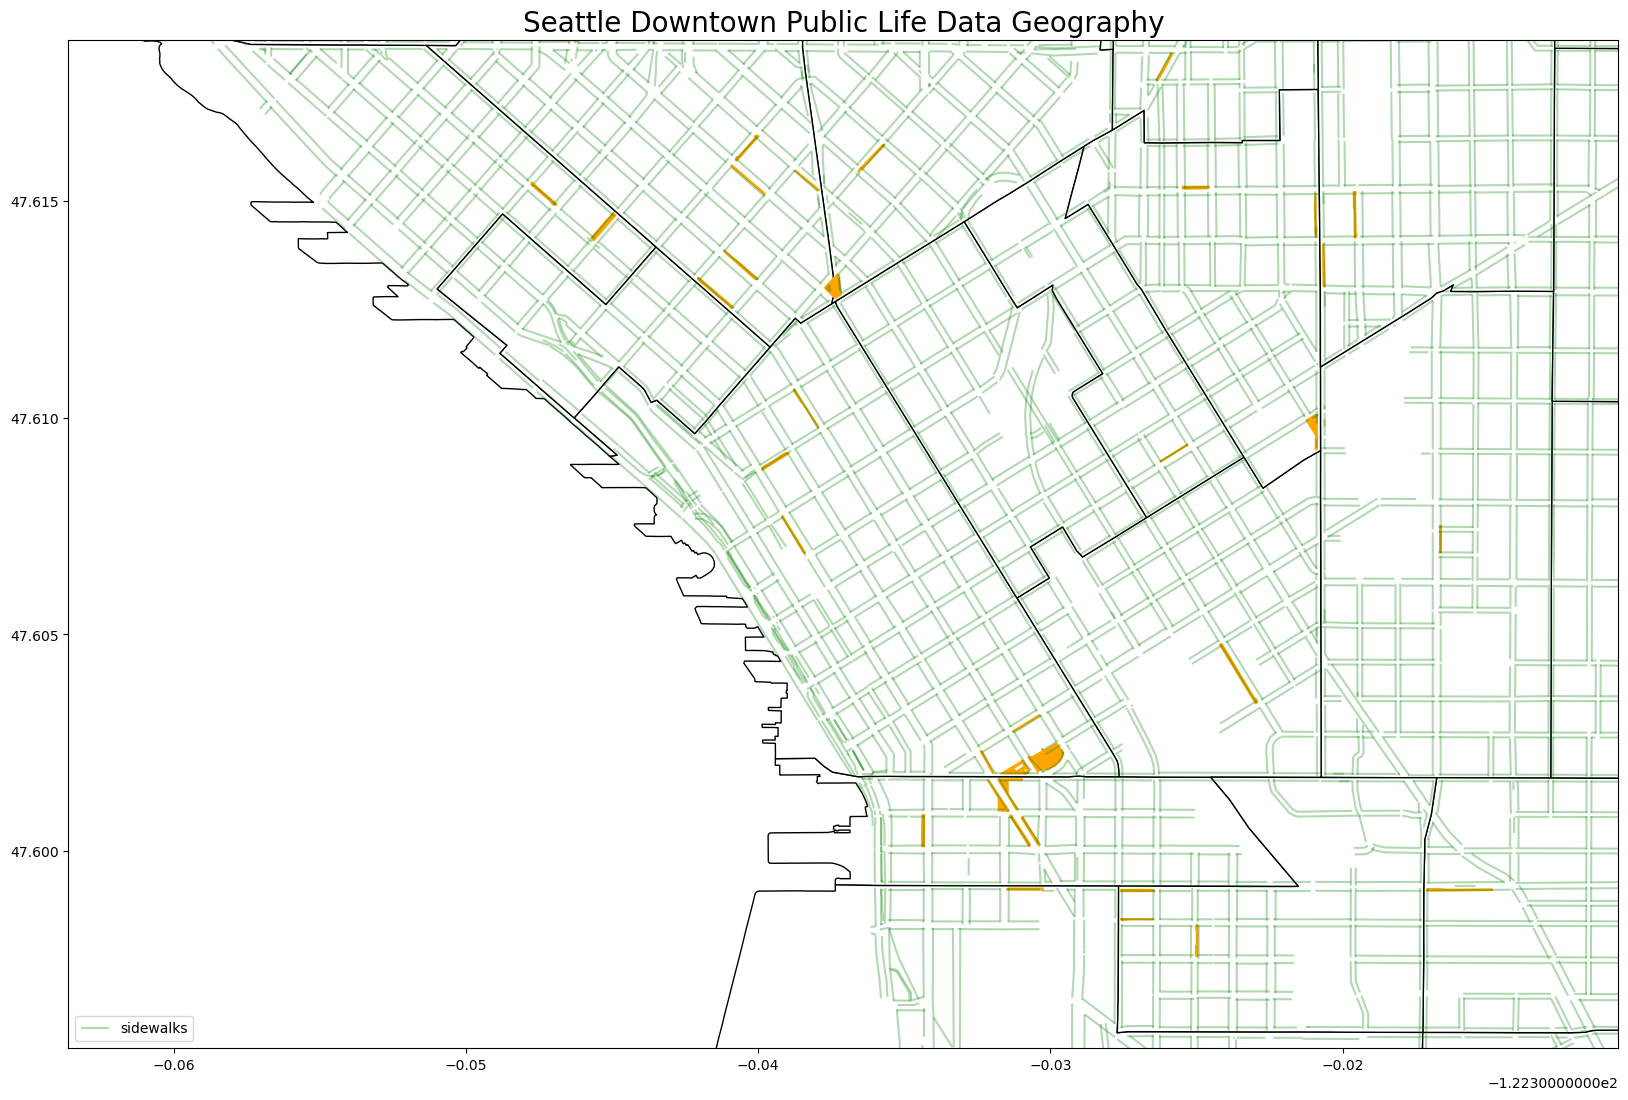

In [163]:
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

# Set the limits
x_min, x_max = -122.363604, -122.310561
y_min, y_max = 47.595458, 47.618721

# Plot tracts_2010 in light gray
tracts_2010.plot(ax=plt.gca(), color='white', edgecolor='black',label = 'census tracts 2010', legend = True)
sidewalks.plot(ax=plt.gca(), color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
# Plot geography on top with orange color and adjusted transparency (alpha)
geography.plot(ax=plt.gca(), color='orange', edgecolor='orange', legend = True,label = 'study areas')

# Set plot title and show legend if needed
plt.title('Seattle Downtown Public Life Data Geography', fontsize = 20)
plt.legend(loc='lower left')  # Display the legend at the lower left corner

# Set the limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

Satellite view from Google Maps focused on Seattle downtown ![Google Maps view](public_data/google_maps_downtown.jpg)


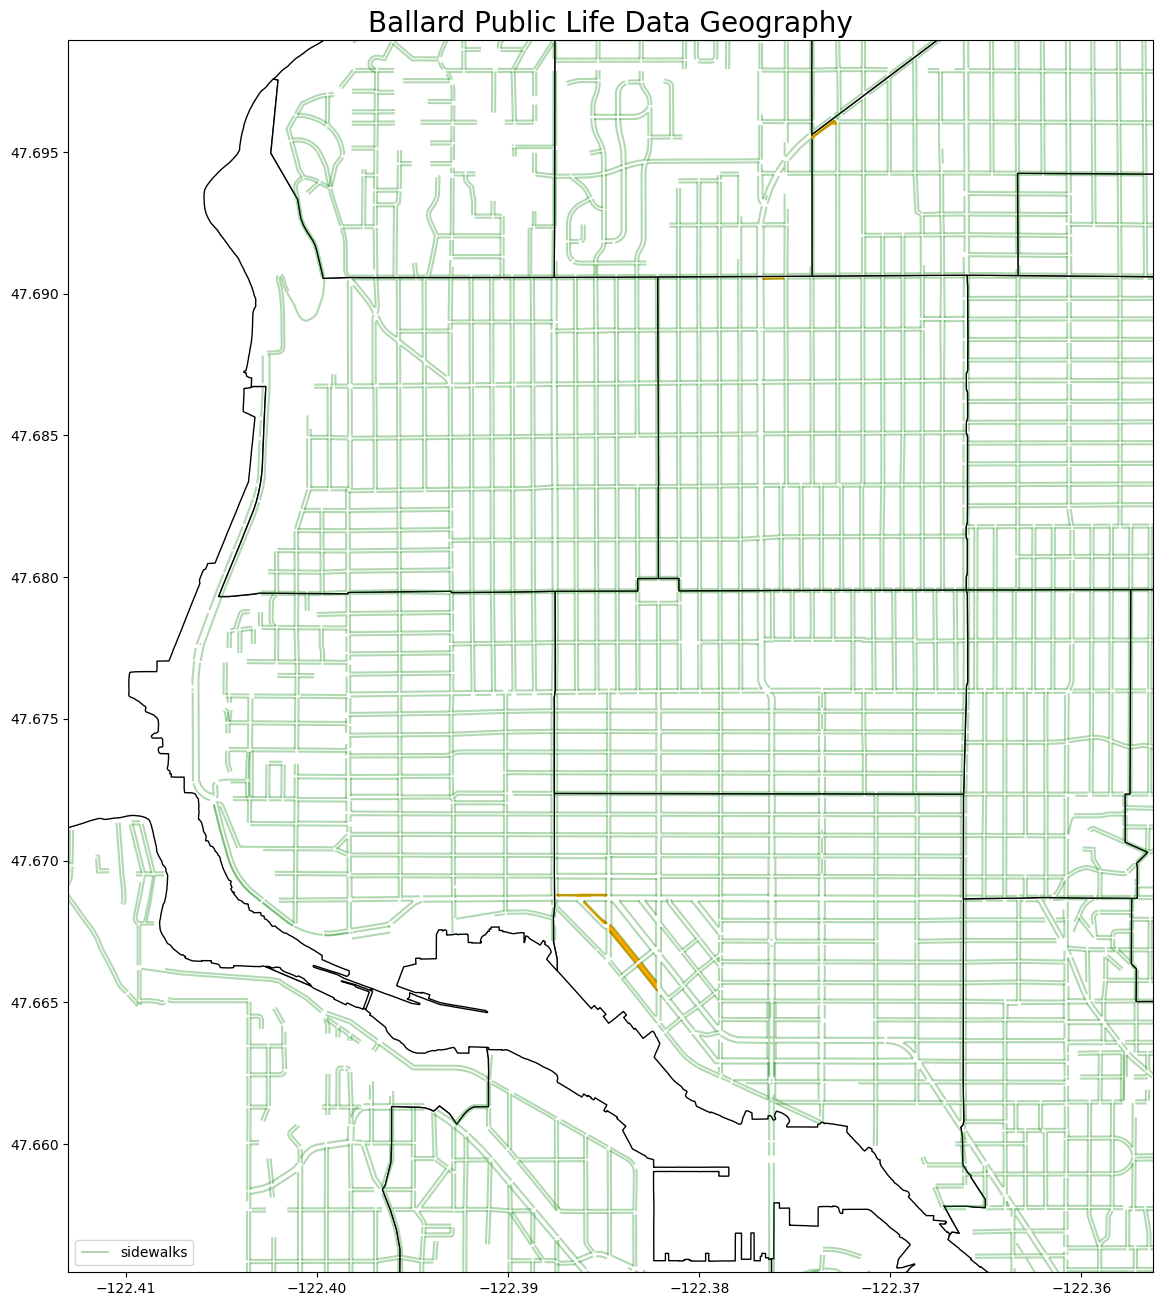

In [164]:
plt.figure(figsize=(20, 16))  # Adjust the figure size as needed

# Set the limits
x_min, x_max = -122.413015, -122.356281
y_min, y_max = 47.655481, 47.698940

# Plot tracts_2010 in light gray
tracts_2010.plot(ax=plt.gca(), color='white', edgecolor='black',label = 'census tracts 2010', legend = True)
sidewalks.plot(ax=plt.gca(), color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
# Plot geography on top with orange color and adjusted transparency (alpha)
geography.plot(ax=plt.gca(), color='orange', edgecolor='orange', legend = True,label = 'study areas')

# Set plot title and show legend if needed
plt.title('Ballard Public Life Data Geography', fontsize = 20)
plt.legend(loc='lower left')  # Display the legend at the lower left corner

# Set the limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

Satellite view from Google Maps focused on Ballard ![Google Maps view ballard](public_data/google_maps_ballard.jpg)

Selected geographies (BAL1, BAL2, BAL3, BAL4, BAL5, BAL6) included are boxed in red. ![Geography view ballard](public_data/ballard_geography.png)
                                                                

In [85]:
# Convert 'moving_time_end' and 'moving_time_start' columns to datetime format
moving['moving_time_end'] = pd.to_datetime(moving['moving_time_end'])
moving['moving_time_start'] = pd.to_datetime(moving['moving_time_start'])

# Calculate the dwell time by subtracting 'moving_time_start' from 'moving_time_end'
moving['dwell_time'] = moving['moving_time_end'] - moving['moving_time_start']

# Convert 'staying_time_end' and 'staying_time_start' columns to datetime format
staying['staying_time_end'] = pd.to_datetime(staying['staying_time_end'])
staying['staying_time_start'] = pd.to_datetime(staying['staying_time_start'])

# Calculate the dwell time by subtracting 'staying_time_start' from 'staying_time_end'
staying['dwell_time'] = staying['staying_time_end'] - staying['staying_time_start']

# Count the number of observations per year for the 'moving_time_start' column
moving_year_counts = moving['moving_time_start'].dt.year.value_counts().reset_index()
moving_year_counts.columns = ['Year', 'Moving Observations']

# Count the number of observations per year for the 'staying_time_start' column
staying_year_counts = staying['staying_time_start'].dt.year.value_counts().reset_index()
staying_year_counts.columns = ['Year', 'Staying Observations']

In [314]:
summary_table = pd.merge(moving_year_counts, staying_year_counts, on='Year', how='outer').fillna(0)
summary_table = summary_table.sort_values('Year')
summary_table


,Year,Moving Observations,Staying Observations
0,2018,1728,6537
1,2019,495,4179
3,2020,56,486
2,2022,99,1248


Visualizing start times

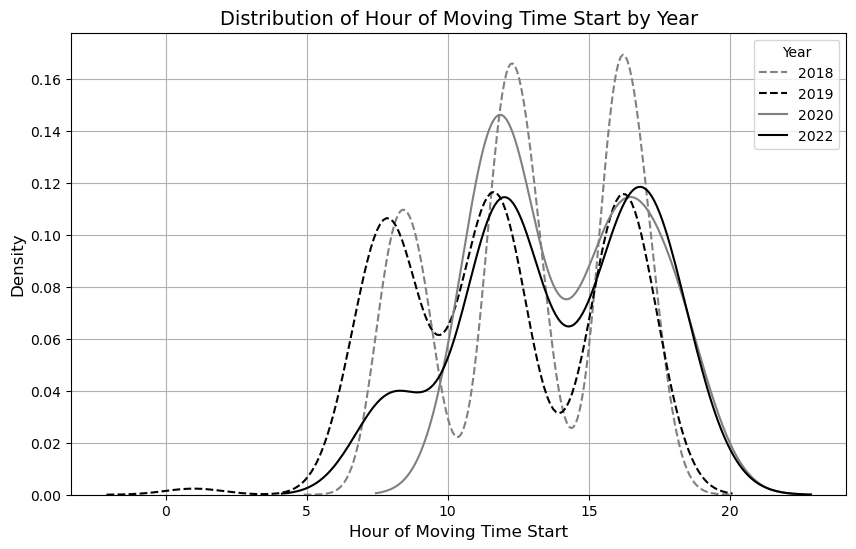

In [107]:
'''
generates a plot to visualize the distribution of the hour of the moving time start for different years.
'''
plt.figure(figsize=(10, 6))  # Increase the figure size

years = moving['moving_time_start'].dt.year.unique()  # Get unique years

# Define a color palette for each year
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(moving[moving['moving_time_start'].dt.year == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color)

plt.xlabel('Hour of Moving Time Start', fontsize=12)  # Adjust the font size of the x-axis label
plt.ylabel('Density', fontsize=12)  # Adjust the font size of the y-axis label
plt.title('Distribution of Hour of Moving Time Start by Year', fontsize=14)  # Adjust the font size of the title
plt.legend(title='Year', fontsize=10)  # Add a legend title and adjust the font size
plt.grid(True)  # Add gridlines to the plot
plt.show()



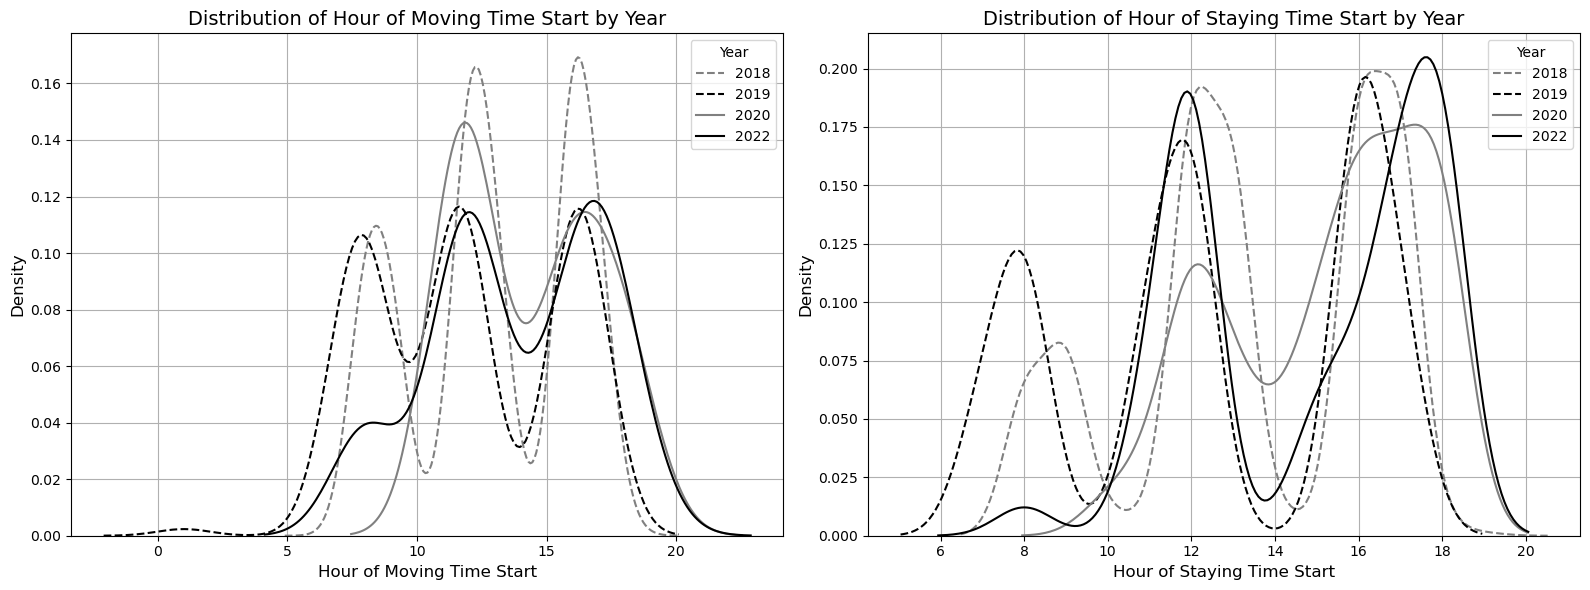

In [108]:
'''
generates a plot to visualize the distribution of the hour of the staying and moving time start for comparison across different years.
'''

plt.figure(figsize=(16, 6))  # Increase the figure size

# Create subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot distribution of hour of moving time start
years = moving['moving_time_start'].dt.year.unique()  # Get unique years
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(moving[moving['moving_time_start'].dt.year == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax1)

ax1.set_xlabel('Hour of Moving Time Start', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Hour of Moving Time Start by Year', fontsize=14)
ax1.legend(title='Year', fontsize=10)
ax1.grid(True)

# Plot distribution of hour of staying time start
years = staying['staying_time_start'].dt.year.unique()  # Get unique years
colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    linestyle = '--' if year in [2018, 2019] else '-'
    color = colors[i]
    
    sns.kdeplot(staying[staying['staying_time_start'].dt.year == year]['staying_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax2)

ax2.set_xlabel('Hour of Staying Time Start', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Hour of Staying Time Start by Year', fontsize=14)
ax2.legend(title='Year', fontsize=10)
ax2.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [316]:

# Convert 'moving_time_start' column to datetime format
moving['moving_time_start'] = pd.to_datetime(moving['moving_time_start'])

# Convert 'staying_time_start' column to datetime format
staying['staying_time_start'] = pd.to_datetime(staying['staying_time_start'])

# Recode the year column
moving['time_start_recoded'] = moving['moving_time_start'].dt.year.apply(create_moving_column)
staying['time_start_recoded'] = staying['staying_time_start'].dt.year.apply(create_moving_column)

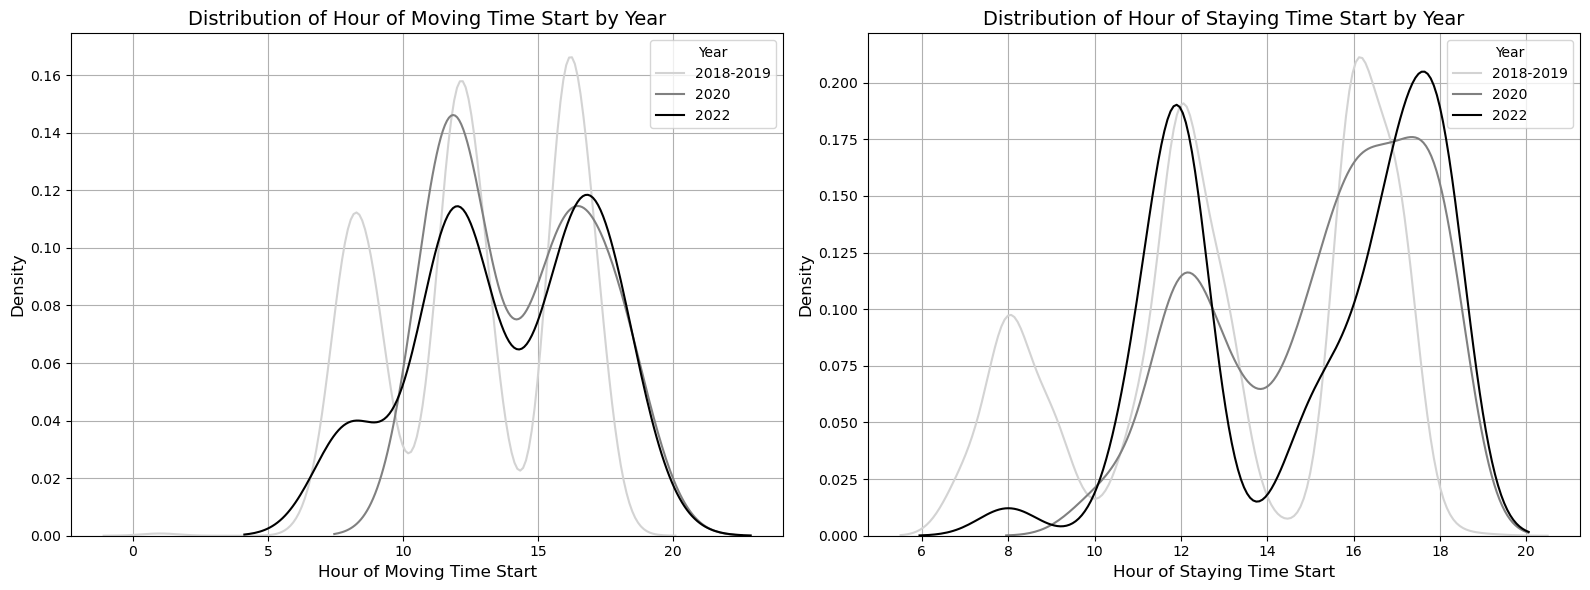

In [317]:
'''
Combining year 2018 and 2019 into one category
'''

plt.figure(figsize=(16, 6))  # Increase the figure size

# Create subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot distribution of hour of moving time start
years = moving['time_start_recoded'].unique()  # Get unique years
# colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    if year == '2018-2019':
        color = 'lightgrey'
    elif year == '2020':
        color = 'grey'
    elif year == '2022':
        color = 'black'
    
    sns.kdeplot(moving[moving['time_start_recoded'] == year]['moving_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax1)

ax1.set_xlabel('Hour of Moving Time Start', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution of Hour of Moving Time Start by Year', fontsize=14)
ax1.legend(title='Year', fontsize=10)
ax1.grid(True)

# Plot distribution of hour of staying time start
years = staying['time_start_recoded'].unique()  # Get unique years
# colors = ['grey', 'black', 'grey', 'black']

for i, year in enumerate(years):
    if year == '2018-2019':
        color = 'lightgrey'
    elif year == '2020':
        color = 'grey'
    elif year == '2022':
        color = 'black'
    
    sns.kdeplot(staying[staying['time_start_recoded'] == year]['staying_time_start'].dt.hour, 
                label=str(year), linestyle=linestyle, color=color, ax=ax2)

ax2.set_xlabel('Hour of Staying Time Start', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Hour of Staying Time Start by Year', fontsize=14)
ax2.legend(title='Year', fontsize=10)
ax2.grid(True)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [ ]:
geography_duplicate = geography.copy()


geography_duplicate['staying_count'] = geography_duplicate['location_i'].map(staying.location_id.value_counts().to_dict())
geography_duplicate['moving_count'] = geography_duplicate['location_i'].map(moving.location_id.value_counts().to_dict())
geography_duplicate['moving_count'].fillna(0, inplace=True)
geography_duplicate['staying_count'].fillna(0, inplace=True)


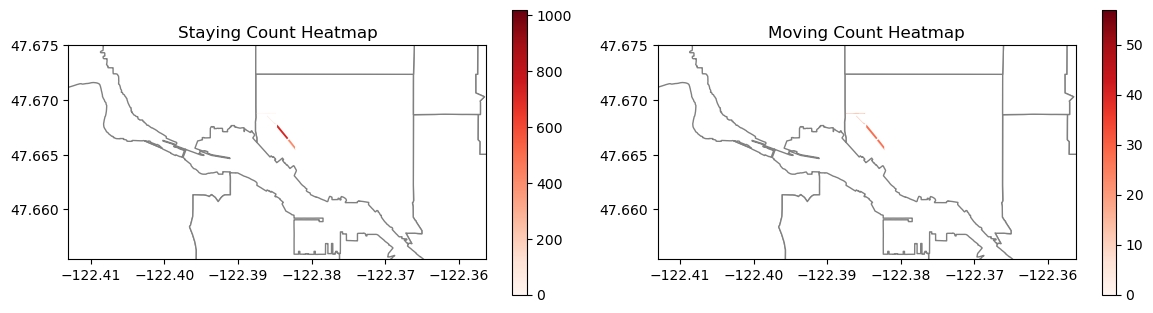

Ballard Staying and Moving Occurances (all years)


In [173]:
x_min, x_max = -122.413015, -122.356281
y_min, y_max = 47.655481, 47.675
# Set plot title and show legend if needed
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot heatmap for staying_count
tracts_2010.plot(ax=axes[0], color='white', edgecolor='gray',label='census tracts 2010', legend=True)
geography.plot(ax=axes[0], column='staying_count', cmap='Reds', legend=True, label='staying',legend_kwds={'shrink': 0.5})

axes[0].set_title('Staying Count Heatmap')  # Set the title for the first subplot
axes[0].set_xlabel('')  # Remove x-axis label for the first subplot
axes[0].set_ylabel('')  # Remove y-axis label for the first subplot
axes[0].set_xlim(x_min, x_max)  # Set x-limit for the first subplot
axes[0].set_ylim(y_min, y_max)  # Set y-limit for the first subplot

# Place the legend outside the plot area
# legend_staying = axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

# Plot heatmap for moving_count
tracts_2010.plot(ax=axes[1], color='white', edgecolor='gray',label='census tracts 2010', legend=True)
geography.plot(ax=axes[1], column='moving_count', cmap='Reds', legend=True, label='moving',legend_kwds={'shrink': 0.5})

axes[1].set_title('Moving Count Heatmap')  # Set the title for the second subplot
axes[1].set_xlabel('')  # Remove x-axis label for the second subplot
axes[1].set_ylabel('')  # Remove y-axis label for the second subplot
axes[1].set_xlim(x_min, x_max)  # Set x-limit for the second subplot
axes[1].set_ylim(y_min, y_max)  # Set y-limit for the second subplot

# Place the legend outside the plot area
# legend_moving = axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

plt.tight_layout()  # Adjust the spacing between subplots
# plt.suptitle('Staying and Moving Occurrences Heatmap', fontsize=18)

plt.show()
print('Ballard Staying and Moving Occurances (all years)')

How are people using Ballard Public Spaces

In [282]:
# Define the locations in Ballard
ballard_geo = ['BAL1', 'BAL2', 'BAL3', 'BAL4', 'BAL5', 'BAL6']

# Filter the data for the years 2018 and 2020 in Ballard
moving_2018 = moving[(moving['moving_time_start'].dt.year == 2018) & (moving['location_id'].isin(ballard_geo))]
moving_2020 = moving[(moving['moving_time_start'].dt.year == 2020) & (moving['location_id'].isin(ballard_geo))]
staying_2018 = staying[(staying['staying_time_start'].dt.year == 2018) & (staying['location_id'].isin(ballard_geo))]
staying_2020 = staying[(staying['staying_time_start'].dt.year == 2020) & (staying['location_id'].isin(ballard_geo))]

# Extract hour and weekday information
staying_2018['hour'] = staying_2018['staying_time_start'].dt.hour
staying_2018['weekday'] = staying_2018['staying_time_start'].dt.weekday  # Monday is 0, Sunday is 6

staying_2020['hour'] = staying_2020['staying_time_start'].dt.hour
staying_2020['weekday'] = staying_2020['staying_time_start'].dt.weekday  # Monday is 0, Sunday is 6

# Define the specific times you are interested in
times_of_interest = [11, 12, 13, 15, 16, 17, 18, 11, 12, 13, 15, 16, 17, 18]
times_of_interest_plot = [f'{hour}:30' for hour in times_of_interest]

# Filter the data for the specified times
filtered_data_2018 = staying_2018[staying_2018['hour'].isin(times_of_interest)]
filtered_data_2020 = staying_2020[staying_2020['hour'].isin(times_of_interest)]

# Map the hour to 'weekday' or 'weekend'
filtered_data_2018['day_type'] = filtered_data_2018['weekday'].apply(lambda x: 'weekday' if x < 5 else 'weekend')
filtered_data_2020['day_type'] = filtered_data_2020['weekday'].apply(lambda x: 'weekday' if x < 5 else 'weekend')

# Calculate the hourly counts for weekdays and weekends
hourly_counts_2018 = filtered_data_2018.groupby(['hour', 'day_type']).size().reset_index(name='observation_counts')
hourly_counts_2018['year'] = 2018

hourly_counts_2020 = filtered_data_2020.groupby(['hour', 'day_type']).size().reset_index(name='observation_counts')
hourly_counts_2020['year'] = 2020

# Merge with the original DataFrame to fill NaN values and populate 'year' with 2018
weekday_combinations_df = pd.DataFrame(list(itertools.product([11, 12, 13, 15, 16, 17, 18], ['weekday'])), columns=['hour', 'day_type'])
weekend_combinations_df = pd.DataFrame(list(itertools.product([11, 12, 13, 14, 15, 16, 17], ['weekend'])), columns=['hour', 'day_type'])

# Merge with the original DataFrame to fill NaN values and populate 'year' with 2018
hourly_counts_2018 = pd.concat([pd.merge(weekday_combinations_df, hourly_counts_2018, on=['hour', 'day_type'], how='left').fillna(0),
                             pd.merge(weekend_combinations_df, hourly_counts_2018, on=['hour', 'day_type'], how='left').fillna(0)])

hourly_counts_2018['year'] = 2018

hourly_counts_2020 = pd.concat([pd.merge(weekday_combinations_df, hourly_counts_2020, on=['hour', 'day_type'], how='left').fillna(0),
                             pd.merge(weekend_combinations_df, hourly_counts_2020, on=['hour', 'day_type'], how='left').fillna(0)])

hourly_counts_2020['year'] = 2020

hourly_counts_2018 = hourly_counts_2018.sort_values(by=['day_type', 'hour'])
hourly_counts_2018['hour_day_type'] = hourly_counts_2018['hour'].astype(str) + '_' + hourly_counts_2018['day_type']

hourly_counts_2020 = hourly_counts_2020.sort_values(by=['day_type', 'hour'])
hourly_counts_2020['hour_day_type'] = hourly_counts_2020['hour'].astype(str) + '_' + hourly_counts_2020['day_type']

# Combine the data for plotting
hourly_counts_staying = pd.concat([hourly_counts_2018, hourly_counts_2020])
hourly_counts_staying['pedestrian_type'] = 'staying'

/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3685211939.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  staying_2018['hour'] = staying_2018['staying_time_start'].dt.hour
/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3685211939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  staying_2018['weekday'] = staying_2018['staying_time_start'].dt.weekday  # Monday is 0, Sunday is 6
/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3685211939.py:14: Setti

In [355]:
staying_2022 = staying[(staying['staying_time_start'].dt.year == 2022) & (staying['location_id'].isin(ballard_geo))]
moving_2022 = moving[(moving['moving_time_start'].dt.year == 2022) & (moving['location_id'].isin(ballard_geo))]

staying_2019 = staying[(staying['staying_time_start'].dt.year == 2019) & (staying['location_id'].isin(ballard_geo))]
moving_2019 = moving[(moving['moving_time_start'].dt.year == 2019) & (moving['location_id'].isin(ballard_geo))]


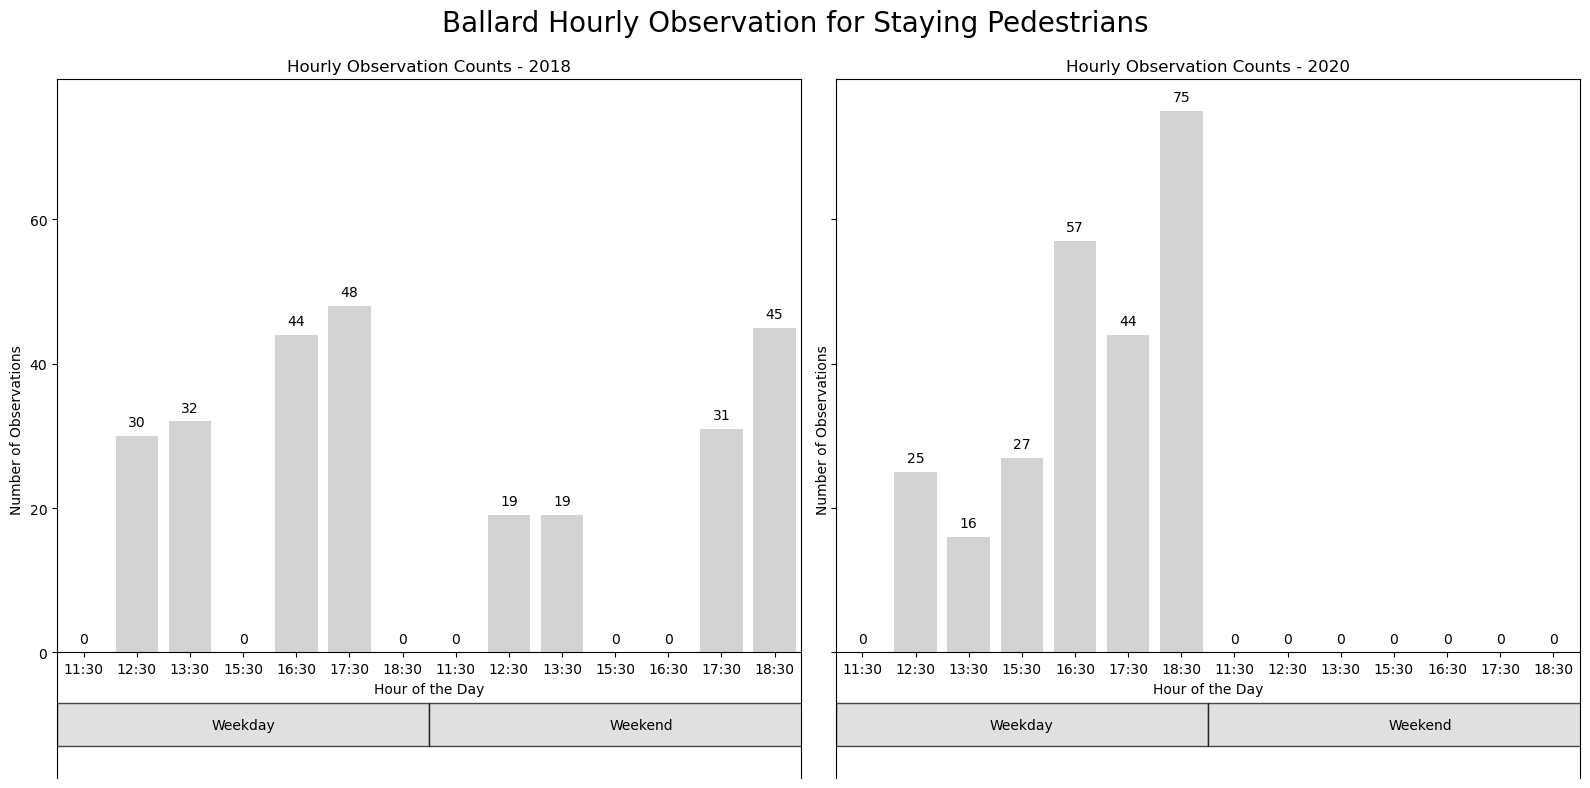

In [283]:
# Plotting subplots for 2018 and 2020
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Loop through years (2018 and 2020)
for i, year in enumerate([2018, 2020]):
    # Filter data for the specific year
    year_data = hourly_counts_staying[hourly_counts_staying['year'] == year]

    # Plotting without color and display values on top of each bar
    sns.barplot(x='hour_day_type', y='observation_counts', data=year_data, errorbar=None, ax=axes[i], color='lightgray')
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    axes[i].set_title(f'Hourly Observation Counts - {year}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Number of Observations')
    axes[i].set_xticks(range(len(times_of_interest)))
    axes[i].spines['bottom'].set_position('zero')
    axes[i].set_xticklabels(times_of_interest_plot)


    axes[i].add_patch(Rectangle((0 - 0.5, -7), 7, -6, facecolor = 'lightgray', edgecolor='black', linewidth=1, alpha=0.7))
    axes[i].text(3, -10, 'Weekday', ha='center', va='center', rotation=0)
    axes[i].add_patch(Rectangle((6.5, -7), 8, -6, facecolor = 'lightgray', edgecolor='black', linewidth=1, alpha=0.7))
    axes[i].text(10.5, -10, 'Weekend', ha='center', va='center', rotation=0)


plt.suptitle('Ballard Hourly Observation for Staying Pedestrians', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust subplot layout

plt.show()

In [309]:
# Extract hour and weekday information for moving pedestrians
moving_2018['hour'] = moving_2018['moving_time_start'].dt.hour
moving_2018['weekday'] = moving_2018['moving_time_start'].dt.weekday  # Monday is 0, Sunday is 6

moving_2020['hour'] = moving_2020['moving_time_start'].dt.hour
moving_2020['weekday'] = moving_2020['moving_time_start'].dt.weekday  # Monday is 0, Sunday is 6

# Filter the data for the specified times for moving pedestrians
filtered_moving_2018 = moving_2018[moving_2018['hour'].isin(times_of_interest)]
filtered_moving_2020 = moving_2020[moving_2020['hour'].isin(times_of_interest)]

# Map the hour to 'weekday' or 'weekend' for moving pedestrians
filtered_moving_2018['day_type'] = filtered_moving_2018['weekday'].apply(lambda x: 'weekday' if x < 5 else 'weekend')
filtered_moving_2020['day_type'] = filtered_moving_2020['weekday'].apply(lambda x: 'weekday' if x < 5 else 'weekend')

# Calculate the hourly counts for weekdays and weekends for moving pedestrians
hourly_counts_moving_2018 = filtered_moving_2018.groupby(['hour', 'day_type']).size().reset_index(name='observation_counts')
hourly_counts_moving_2018['year'] = 2018
# hourly_counts_moving_2018['pedestrian_type'] = 'moving'

hourly_counts_moving_2020 = filtered_moving_2020.groupby(['hour', 'day_type']).size().reset_index(name='observation_counts')
hourly_counts_moving_2020['year'] = 2020
# hourly_counts_moving_2020['pedestrian_type'] = 'moving'

# Merge with the original DataFrame to fill NaN values and populate 'year' with 2018 for moving pedestrians
hourly_counts_moving_2018 = pd.concat([pd.merge(weekday_combinations_df, hourly_counts_moving_2018, on=['hour', 'day_type'], how='left').fillna(0),
                                       pd.merge(weekend_combinations_df, hourly_counts_moving_2018, on=['hour', 'day_type'], how='left').fillna(0)])

hourly_counts_moving_2018['year'] = 2018

hourly_counts_moving_2020 = pd.concat([pd.merge(weekday_combinations_df, hourly_counts_moving_2020, on=['hour', 'day_type'], how='left').fillna(0),
                                       pd.merge(weekend_combinations_df, hourly_counts_moving_2020, on=['hour', 'day_type'], how='left').fillna(0)])

hourly_counts_moving_2020['year'] = 2020

hourly_counts_moving_2018 = hourly_counts_moving_2018.sort_values(by=['day_type', 'hour'])
hourly_counts_moving_2018['hour_day_type'] = hourly_counts_moving_2018['hour'].astype(str) + '_' + hourly_counts_moving_2018['day_type']

hourly_counts_moving_2020 = hourly_counts_moving_2020.sort_values(by=['day_type', 'hour'])
hourly_counts_moving_2020['hour_day_type'] = hourly_counts_moving_2020['hour'].astype(str) + '_' + hourly_counts_moving_2020['day_type']

# Combine the data for plotting
hourly_counts_combined_moving = pd.concat([hourly_counts_moving_2018, hourly_counts_moving_2020])
hourly_counts_combined_moving['pedestrian_type'] = 'moving'



/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3639467737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_2018.loc[:, 'hour'] = moving_2018['moving_time_start'].dt.hour
/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3639467737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moving_2018.loc[:, 'weekday'] = moving_2018['moving_time_start'].dt.weekday  # Monday is 0, Sunday is 6
/var/folders/m4/2x0gw_kj5tv31gf3pgyw9jpm0000gn/T/ipykernel_15803/3639467737.py:5: 

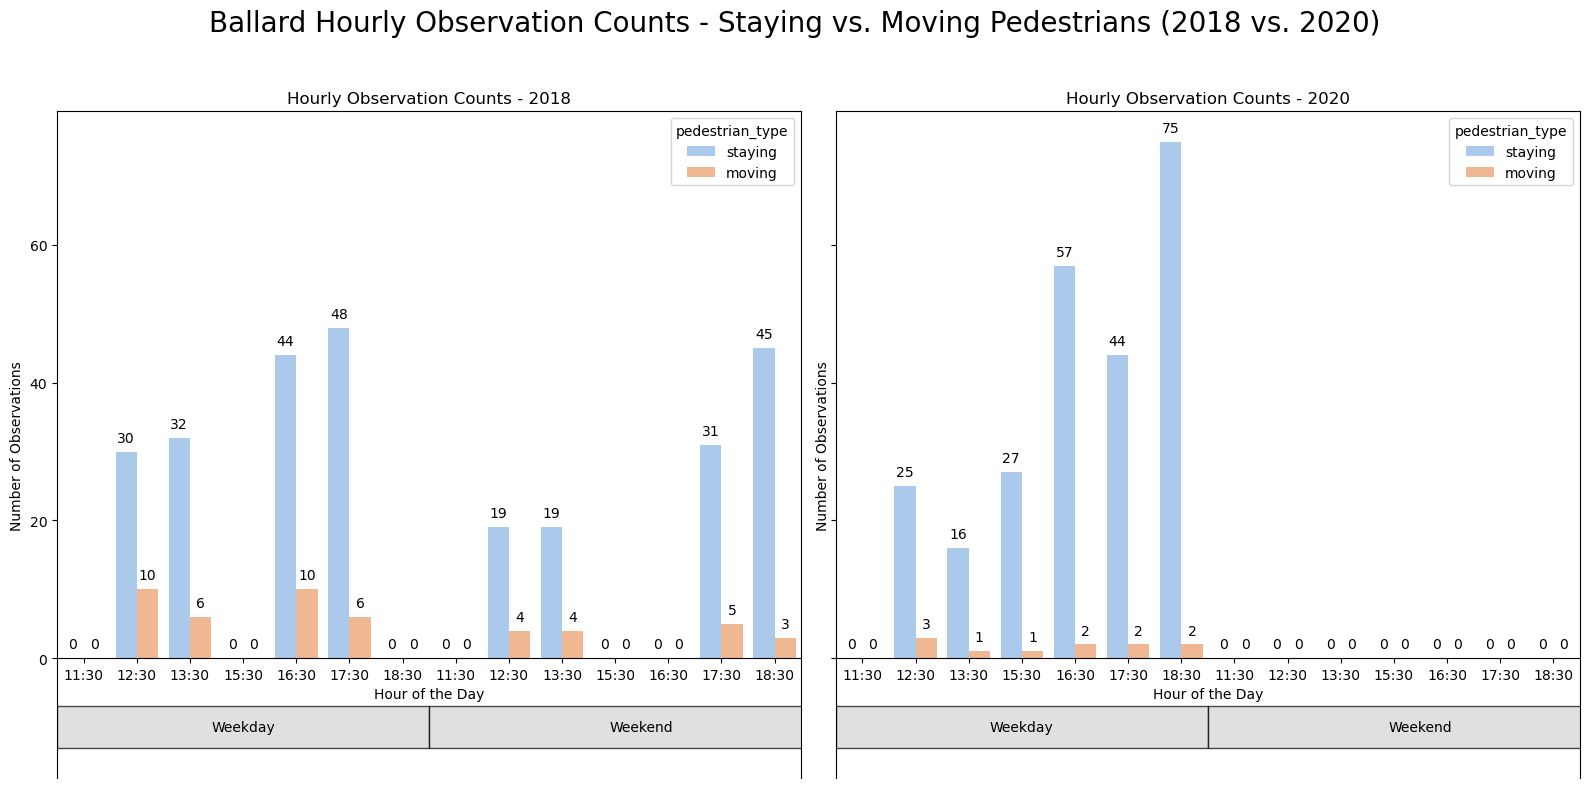

In [291]:
# Plotting subplots for 2018 and 2020
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Loop through years (2018 and 2020)
for i, year in enumerate([2018, 2020]):
    # Filter data for the specific year
    year_data_staying = hourly_counts_staying[hourly_counts_staying['year'] == year]
    year_data_moving = hourly_counts_combined_moving[hourly_counts_combined_moving['year'] == year]

    # Plotting box plots for staying and moving pedestrians
    sns.barplot(x='hour_day_type', y='observation_counts', hue='pedestrian_type', data=pd.concat([year_data_staying, year_data_moving]), ax=axes[i], palette='pastel')

    # # Plotting without color and display values on top of each bar
    # sns.barplot(x='hour_day_type', y='observation_counts', data=year_data, errorbar=None, ax=axes[i], color='lightgray')
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    axes[i].set_title(f'Hourly Observation Counts - {year}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Number of Observations')
    axes[i].set_xticks(range(len(times_of_interest)))
    axes[i].spines['bottom'].set_position('zero')
    axes[i].set_xticklabels(times_of_interest_plot)


    axes[i].add_patch(Rectangle((0 - 0.5, -7), 7, -6, facecolor = 'lightgray', edgecolor='black', linewidth=1, alpha=0.7))
    axes[i].text(3, -10, 'Weekday', ha='center', va='center', rotation=0)
    axes[i].add_patch(Rectangle((6.5, -7), 8, -6, facecolor = 'lightgray', edgecolor='black', linewidth=1, alpha=0.7))
    axes[i].text(10.5, -10, 'Weekend', ha='center', va='center', rotation=0)

plt.suptitle('Ballard Hourly Observation Counts - Staying vs. Moving Pedestrians (2018 vs. 2020)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust subplot layout

plt.show()

Linger Factor

In [360]:
# Extract hour and weekday information for staying pedestrians
staying_2018['hour'] = staying_2018['staying_time_start'].dt.hour
staying_2018['minute'] = staying_2018['staying_time_start'].dt.minute

# Extract hour and weekday information for moving pedestrians
moving_2018['hour'] = moving_2018['moving_time_start'].dt.hour
moving_2018['minute'] = moving_2018['moving_time_start'].dt.minute

# Calculate the average counts per 20-minute period for staying pedestrians
hourly_counts_staying_2018 = staying_2018.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_staying_2018 = hourly_counts_staying_2018['observation_counts'].mean()

# Calculate the average counts per 20-minute period for moving pedestrians
hourly_counts_moving_2018 = moving_2018.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_moving_2018 = hourly_counts_moving_2018['observation_counts'].mean()

# Extract hour and weekday information for staying pedestrians in 2020
staying_2020['hour'] = staying_2020['staying_time_start'].dt.hour
staying_2020['minute'] = staying_2020['staying_time_start'].dt.minute

# Extract hour and weekday information for moving pedestrians in 2020
moving_2020['hour'] = moving_2020['moving_time_start'].dt.hour
moving_2020['minute'] = moving_2020['moving_time_start'].dt.minute

# Calculate the average counts per 20-minute period for staying pedestrians in 2020
hourly_counts_staying_2020 = staying_2020.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_staying_2020 = hourly_counts_staying_2020['observation_counts'].mean()

# Calculate the average counts per 20-minute period for moving pedestrians in 2020
hourly_counts_moving_2020 = moving_2020.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_moving_2020 = hourly_counts_moving_2020['observation_counts'].mean()

# Calculate the average counts per 20-minute period for staying pedestrians in 2022
staying_2022['hour'] = staying_2022['staying_time_start'].dt.hour
staying_2022['minute'] = staying_2022['staying_time_start'].dt.minute

hourly_counts_staying_2022 = staying_2022.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_staying_2022 = hourly_counts_staying_2022['observation_counts'].mean()

# Calculate the average counts per 20-minute period for moving pedestrians in 2022
moving_2022['hour'] = moving_2022['moving_time_start'].dt.hour
moving_2022['minute'] = moving_2022['moving_time_start'].dt.minute

hourly_counts_moving_2022 = moving_2022.groupby(['hour', 'minute']).size().reset_index(name='observation_counts')
average_counts_moving_2022 = hourly_counts_moving_2022['observation_counts'].mean()


print(f'Average counts per 20-minute period for staying pedestrians in Ballard (2018): {average_counts_staying_2018}')
print(f'Average counts per 20-minute period for moving pedestrians in Ballard (2018): {average_counts_moving_2018}')
print(f'Average counts per 20-minute period for staying pedestrians in Ballard (2020): {average_counts_staying_2020}')
print(f'Average counts per 20-minute period for moving pedestrians in Ballard (2020): {average_counts_moving_2020}')
print(f'Average counts per 20-minute period for staying pedestrians in Ballard (2022): {average_counts_staying_2022}')
print(f'Average counts per 20-minute period for moving pedestrians in Ballard (2022): {average_counts_moving_2022}')


Average counts per 20-minute period for staying pedestrians in Ballard (2018): 10.642857142857142
Average counts per 20-minute period for moving pedestrians in Ballard (2018): 1.28
Average counts per 20-minute period for staying pedestrians in Ballard (2020): 40.666666666666664
Average counts per 20-minute period for moving pedestrians in Ballard (2020): 1.0
Average counts per 20-minute period for staying pedestrians in Ballard (2022): 42.074074074074076
Average counts per 20-minute period for moving pedestrians in Ballard (2022): 1.0566037735849056


In [361]:
# Calculate the linger factor for year 2018
linger_factor_2018 = (average_counts_staying_2018 / average_counts_moving_2018) * 100

# Calculate the linger factor for year 2020
linger_factor_2020 = (average_counts_staying_2020 / average_counts_moving_2020) * 100

# Calculate the linger factor for year 2022
linger_factor_2022 = (average_counts_staying_2022 / average_counts_moving_2022) * 100

# Report the linger factors
print(f"Linger factor for year 2018: {linger_factor_2018:.2f}%")
print(f"Linger factor for year 2020: {linger_factor_2020:.2f}%")
print(f"Linger factor for year 2022: {linger_factor_2022:.2f}%")


Linger factor for year 2018: 831.47%
Linger factor for year 2020: 4066.67%
Linger factor for year 2022: 3982.01%


Heatmaps and animations

In [356]:
geography_duplicate = geography.copy()
geography_duplicate['staying_count'] = geography_duplicate['location_i'].map(staying.location_id.value_counts().to_dict())
geography_duplicate['moving_count'] = geography_duplicate['location_i'].map(moving.location_id.value_counts().to_dict())
geography_duplicate['staying_count_2018'] = geography_duplicate['location_i'].map(staying_2018.location_id.value_counts().to_dict())
geography_duplicate['moving_count_2018'] = geography_duplicate['location_i'].map(moving_2018.location_id.value_counts().to_dict())
geography_duplicate['staying_count_2019'] = geography_duplicate['location_i'].map(staying_2019.location_id.value_counts().to_dict())
geography_duplicate['moving_count_2019'] = geography_duplicate['location_i'].map(moving_2019.location_id.value_counts().to_dict())
geography_duplicate['staying_count_2020'] = geography_duplicate['location_i'].map(staying_2020.location_id.value_counts().to_dict())
geography_duplicate['moving_count_2020'] = geography_duplicate['location_i'].map(moving_2020.location_id.value_counts().to_dict())
geography_duplicate['staying_count_2022'] = geography_duplicate['location_i'].map(staying_2022.location_id.value_counts().to_dict())
geography_duplicate['moving_count_2022'] = geography_duplicate['location_i'].map(moving_2022.location_id.value_counts().to_dict())

geography_duplicate.fillna(0, inplace=True)


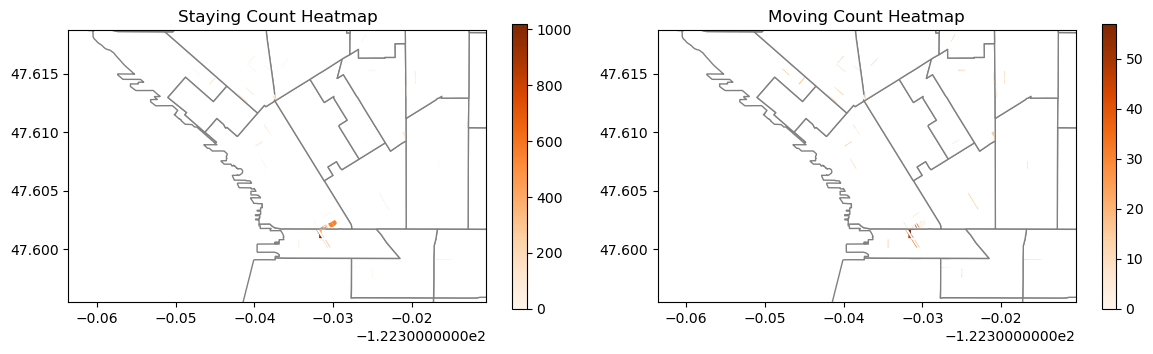

Downtown Staying and Moving Occurances (all years)


In [321]:
'''
generates a heat map to visualize the distribution of the staying and moving occurances summed for all years.
'''

# Set the limits
x_min, x_max = -122.363604, -122.310561
y_min, y_max = 47.595458, 47.618721
# Set plot title and show legend if needed
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot heatmap for staying_count
# Plot tracts_2010 in light gray
tracts_2010.plot(ax=axes[0], color='white', edgecolor='gray',label = 'census tracts 2010', legend = True)
# sidewalks.plot(ax=axes[0], color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
geography_duplicate.plot(ax=axes[0],column='staying_count', cmap='Oranges', legend=True, label = 'staying',legend_kwds={'shrink': 0.5})

axes[0].set_title('Staying Count Heatmap')  # Set the title for the first subplot
axes[0].set_xlabel('')  # Remove x-axis label for the first subplot
axes[0].set_ylabel('')  # Remove y-axis label for the first subplot
axes[0].set_xlim(x_min, x_max)  # Set x-limit for the first subplot
axes[0].set_ylim(y_min, y_max)  # Set y-limit for the first subplot

# Plot heatmap for moving_count
tracts_2010.plot(ax=axes[1], color='white', edgecolor='gray',label = 'census tracts 2010', legend = True)
# sidewalks.plot(ax=axes[1], color='green', edgecolor='green',alpha = 0.3, label = 'sidewalks')
geography_duplicate.plot(ax=axes[1],column='moving_count', cmap='Oranges', legend=True, label = 'moving',legend_kwds={'shrink': 0.5})
# Plot the heatmap on the second subplot

axes[1].set_title('Moving Count Heatmap')  # Set the title for the second subplot
axes[1].set_xlabel('')  # Remove x-axis label for the second subplot
axes[1].set_ylabel('')  # Remove y-axis label for the second subplot
axes[1].set_xlim(x_min, x_max)  # Set x-limit for the second subplot
axes[1].set_ylim(y_min, y_max)  # Set y-limit for the second subplot

plt.tight_layout()  # Adjust the spacing between subplots
# plt.suptitle('Downtown Staying and Moving Occurances', fontsize = 20)
# plt.legend(loc='lower left')  # Display the legend at the lower left corner
plt.show()
print('Downtown Staying and Moving Occurances (all years)')

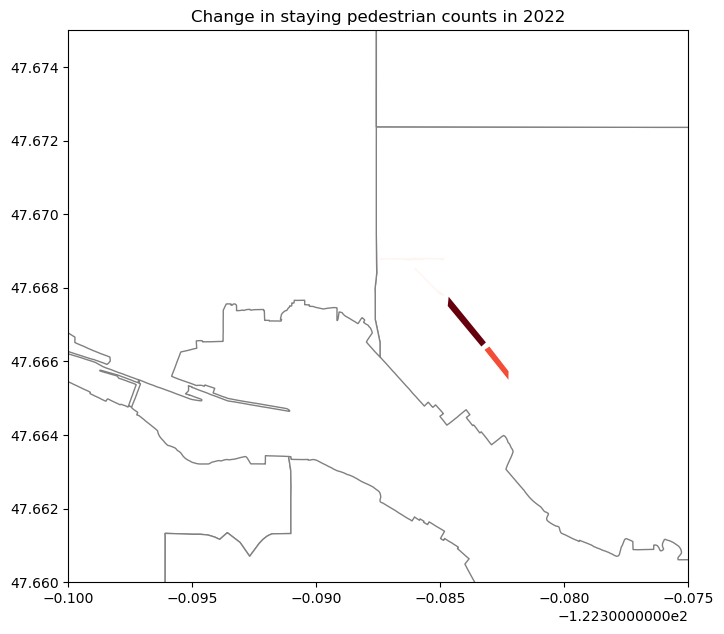

In [358]:
# Define the columns you want to visualize
columns_to_visualize = ['staying_count_2018','staying_count_2020', 'staying_count_2020', 'staying_count_2022']
column_titles = ['2018','2019', '2020', '2022']  # Custom titles for each column

# Set the limits
x_min, x_max = -122.4, -122.375
y_min, y_max = 47.66, 47.675

# Create a base map
fig, axes = plt.subplots(figsize=(8, 8))
# Set the limits
axes.set_xlim(x_min, x_max)
axes.set_ylim(y_min, y_max)

# Initialization function for the animation
def init():
    pass

# Update function for each frame of the animation
def update(frame):
    axes.clear()
    tracts_2010.plot(ax=axes, color='white', edgecolor='gray', label='Census Tracts 2010')
    
    # Plot the geography data
    geography_duplicate.plot(ax=axes, column=columns_to_visualize[frame], cmap='Reds', legend_kwds={'shrink': 0.5})
    
    axes.set_title(f'Change in staying pedestrian counts in {column_titles[frame]}')  # Set custom title
    axes.set_xlim(x_min, x_max)
    axes.set_ylim(y_min, y_max)
    # axes.set_axis_off()

# Create the animation
animation = FuncAnimation(fig, update, init_func=init, frames=len(columns_to_visualize), repeat=False, interval=1000)

# Save the animation as a GIF
animation.save(input_path + 'animation.gif', writer='pillow')  # You need to have ImageMagick installed for this

# Show the animation (optional)
plt.show()